In [46]:
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from pandas.plotting import scatter_matrix
tf.__version__ 


'2.11.0'

In [47]:
#Getting, checking, cleaning data
data_frame = pd.read_csv("C:/Users/lukas/OneDrive/Dokumenty/healthcare-dataset-stroke-data.csv")
print(data_frame)

         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  former

In [48]:
data_frame.info() #observed missing data in BMI column 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [49]:
#finding N/A and duplicates
print(data_frame.isna().sum()) 
print(data_frame.duplicated().sum())
# 201 positions with N/A, no duplicates.

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
0


In [50]:
print(data_frame['age'].min(), data_frame['age'].max()) #verifying data range of patients, values are under 1 ,
#as children less than one year old are included 

0.08 82.0


In [51]:
data_frame.work_type.value_counts() #working type summary 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [52]:
data_frame.smoking_status.value_counts() #smoking status summary 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [53]:
data_frame = data_frame.drop('id',axis=1) # Dropping ID column as it is not necassary for the calculation
data_frame.bmi.fillna(data_frame.bmi.mean(),inplace=True) #replace N/A values with the mean value of BMI section

In [54]:
data_frame.gender.value_counts() #Finding gender "other" in data set as potential place for replacement 

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [55]:
data_frame["gender"] = data_frame["gender"].replace(["Other"],"Male") #replaced other gender with male gender 
data_frame.gender.value_counts() # checking if replaced correctly 

Female    2994
Male      2116
Name: gender, dtype: int64

In [56]:
data_frame.info() #verifying wether there is no missing data again. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


<class 'pandas.core.series.Series'>
RangeIndex: 5110 entries, 0 to 5109
Series name: avg_glucose_level
Non-Null Count  Dtype  
--------------  -----  
5110 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


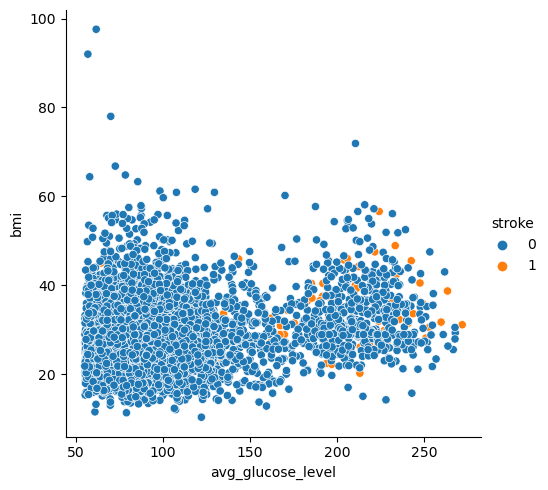

In [57]:
#comparison of bmi and glucose level as eventual factors of stroke. 
#orange dots (hue) are represnting levels of bmi and glucose that resulted in stroke for particular patient.
#it is visible that some certain level of each variable, might put patient in danger of stroke. 
sns.relplot(data = data_frame, x = "avg_glucose_level", y="bmi", hue = "stroke" )

data_frame.avg_glucose_level.info()

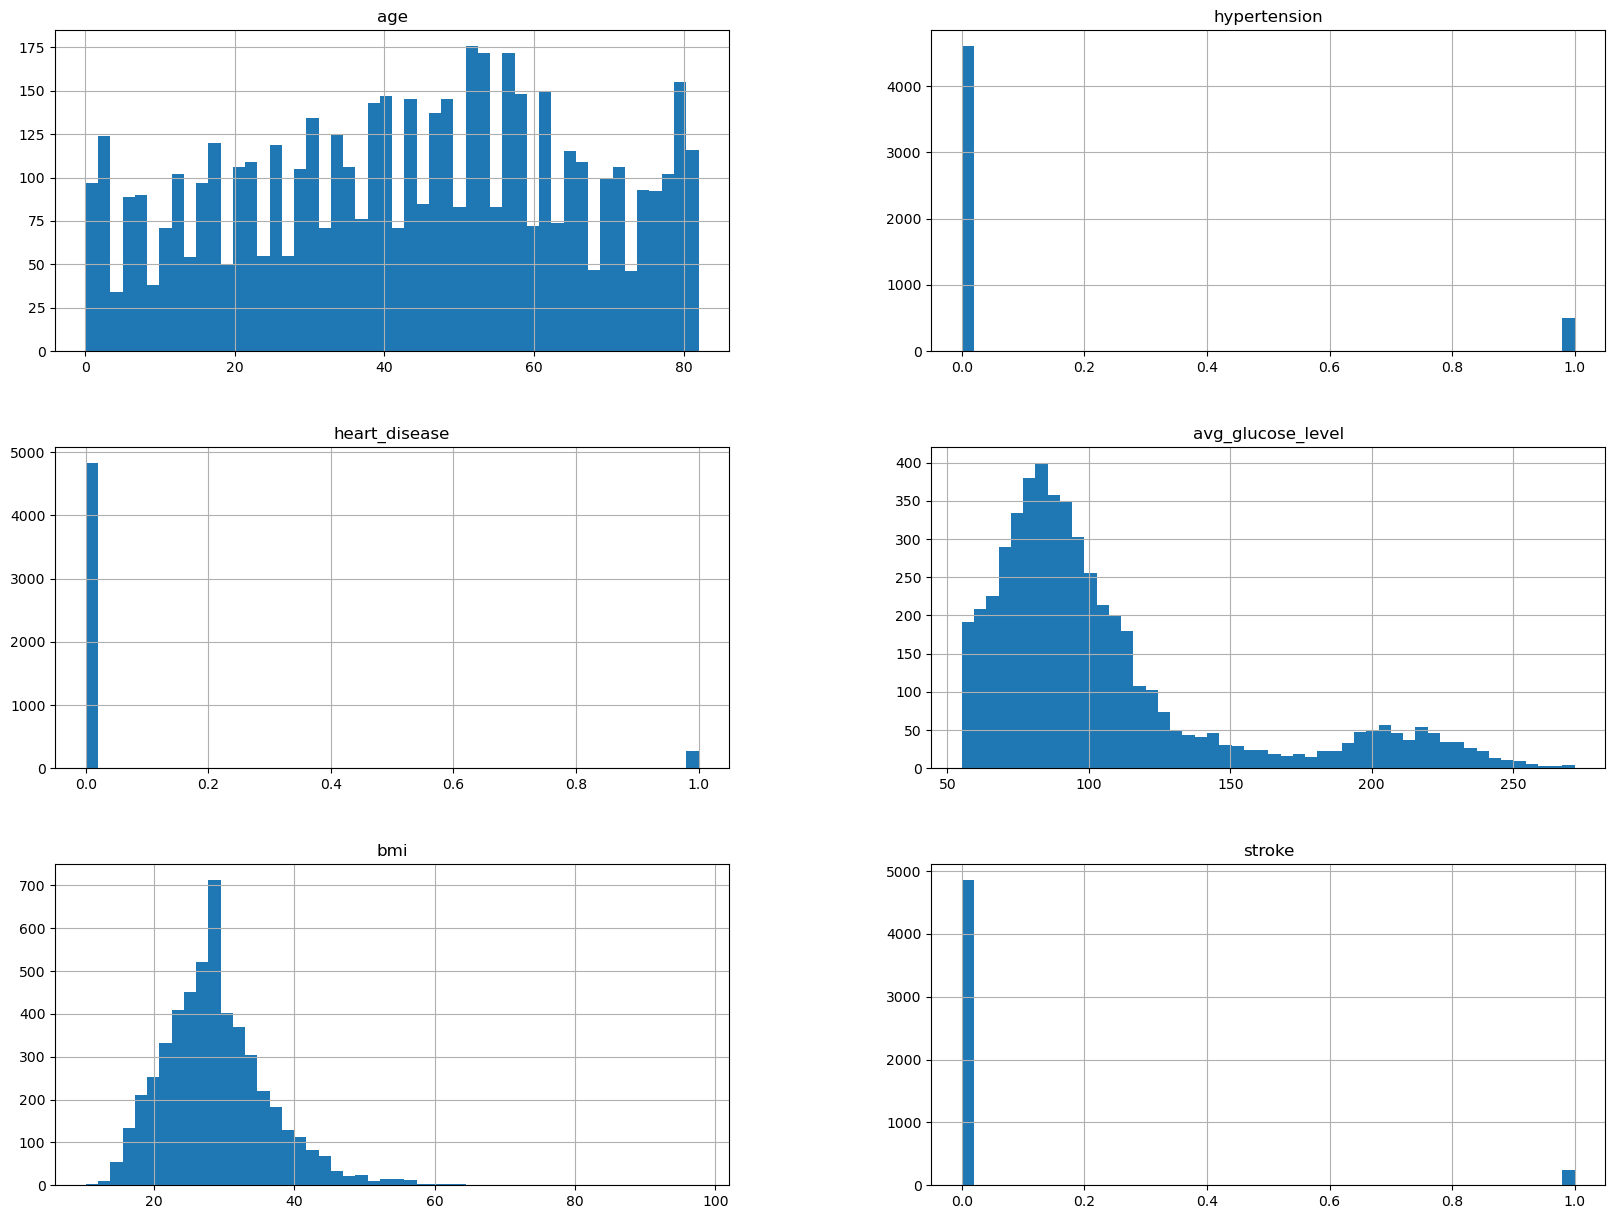

In [58]:
data_frame.hist(bins=50, figsize=(20,15)) #verification of variables distribution
plt.show()

#it is noticible that age has regular distribution. 
#hypertention and heart desease are categorical variables that takes value 0 or 1 so their distribution won't be regular.
#both avg glucose level and BMI level, seem to have right-sided asymethric characteristic of distribution.
#It means that most of population takes values lower than an average. 


In [59]:
#correlations verification 
correlation_matrix = data_frame.corr()  #correlation based on stroke 
print(correlation_matrix["stroke"].sort_values(ascending=False))

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.038947
Name: stroke, dtype: float64


<AxesSubplot: >

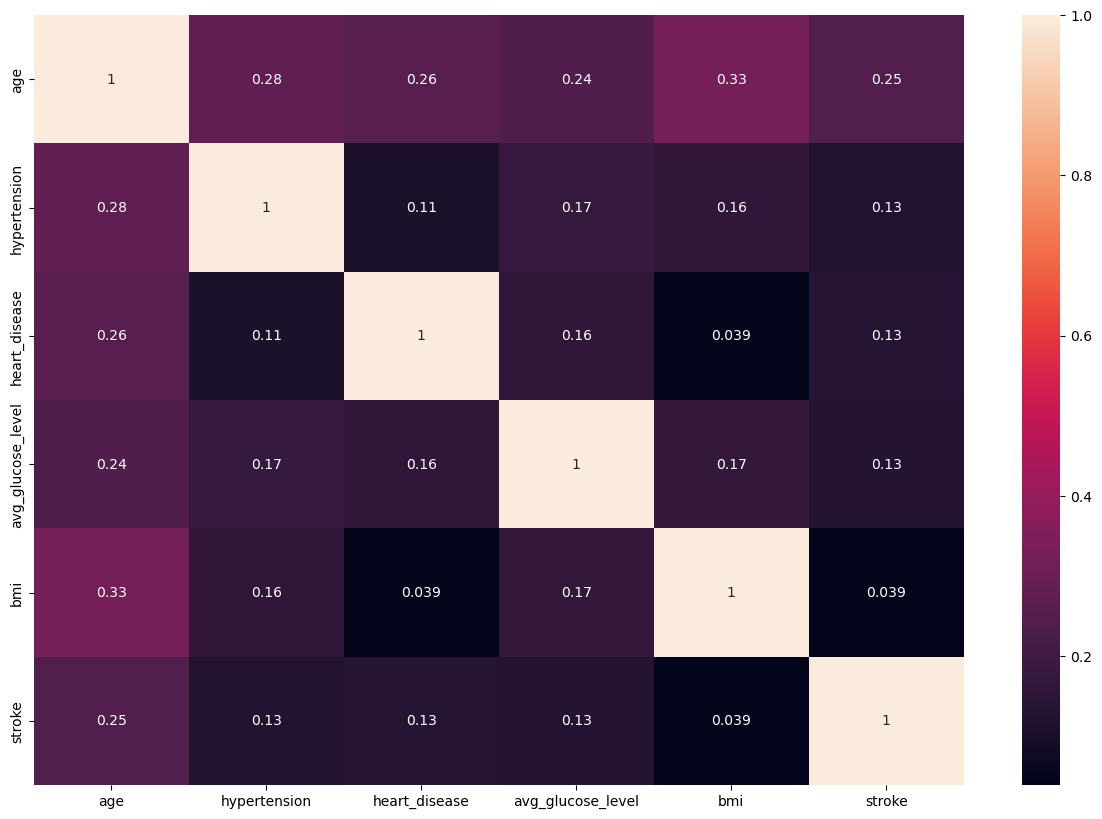

In [60]:
plt.figure(figsize=(15,10)) #visualization of correlation of variables 
sns.heatmap(correlation_matrix,annot=True) 
#There is no strong correlation between variables.

array([[<AxesSubplot: xlabel='stroke', ylabel='stroke'>,
        <AxesSubplot: xlabel='avg_glucose_level', ylabel='stroke'>,
        <AxesSubplot: xlabel='hypertension', ylabel='stroke'>,
        <AxesSubplot: xlabel='bmi', ylabel='stroke'>],
       [<AxesSubplot: xlabel='stroke', ylabel='avg_glucose_level'>,
        <AxesSubplot: xlabel='avg_glucose_level', ylabel='avg_glucose_level'>,
        <AxesSubplot: xlabel='hypertension', ylabel='avg_glucose_level'>,
        <AxesSubplot: xlabel='bmi', ylabel='avg_glucose_level'>],
       [<AxesSubplot: xlabel='stroke', ylabel='hypertension'>,
        <AxesSubplot: xlabel='avg_glucose_level', ylabel='hypertension'>,
        <AxesSubplot: xlabel='hypertension', ylabel='hypertension'>,
        <AxesSubplot: xlabel='bmi', ylabel='hypertension'>],
       [<AxesSubplot: xlabel='stroke', ylabel='bmi'>,
        <AxesSubplot: xlabel='avg_glucose_level', ylabel='bmi'>,
        <AxesSubplot: xlabel='hypertension', ylabel='bmi'>,
        <AxesSubplot: xl

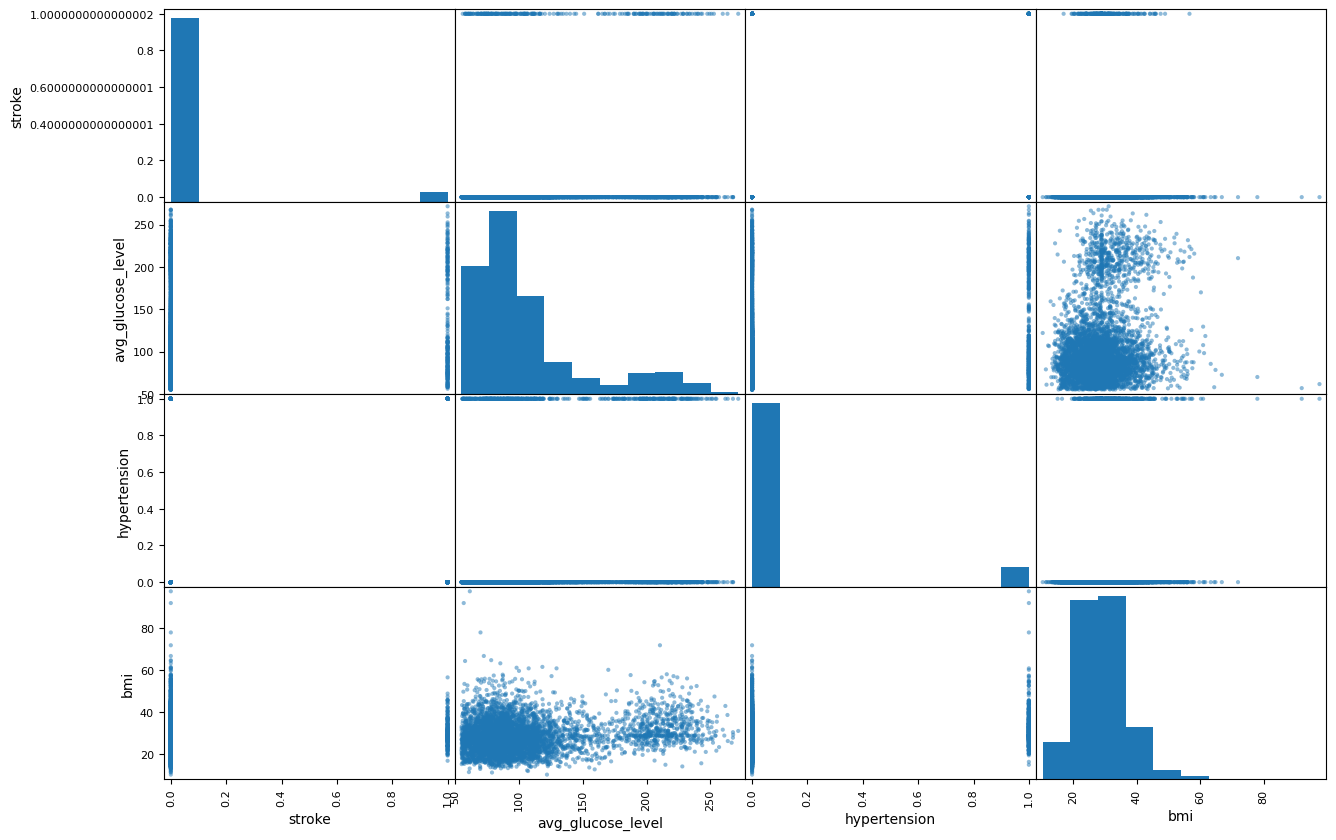

In [61]:
#Using attributes - stroke, glucose level, hypertention and bmi and verifying its dispersion on scatter matrix to find some correlation
attributes = ["stroke","avg_glucose_level",'hypertension','bmi']
scatter_matrix(data_frame[attributes], figsize=(15, 10))
#There potentially can be correlation between BMI and glucose level

In [78]:
# cross validation using random fold split. N_splits = 1 - leave one out as we have 11 variables to maintain 10 folds split.
# stratified ShuffleSplit cross-validator. provides train/test indices to split data in train/test sets.
# this cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
# provides train/test indices to split data in train/test sets.

data_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42) #20% - test set ; 80% - training set 
for train_index, test_index in data_split.split(data_frame,data_frame.stroke ):
    train_set = data_frame.loc[train_index] #(4088, 11)
    test_set =  data_frame.loc[test_index]  #(1022, 11)

In [79]:
#Split check     # 1 - represents cases with stroke 
print('shape  =', train_set.shape)
print(train_set.stroke.value_counts())

shape  = (4088, 11)
0    3889
1     199
Name: stroke, dtype: int64


In [80]:
#Split check     # 1 - represents cases with stroke 
print('shape  =', test_set.shape) 
print(test_set.stroke.value_counts())

shape  = (1022, 11)
0    972
1     50
Name: stroke, dtype: int64


In [81]:
X_train = train_set.drop('stroke',axis=1) #dropping stroke as decision variable from the data set 
Y_train = train_set.stroke.copy()

In [82]:
X_test = test_set.drop('stroke',axis=1)  #dropping stroke as decision variable from the data set 
Y_test = test_set.stroke.copy()

In [83]:
X_train.info() #verifying corectness 
X_train   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 845 to 5052
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                4088 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown
...,...,...,...,...,...,...,...,...,...,...
1434,Female,45.0,0,0,Yes,Private,Urban,92.86,35.1,formerly smoked
461,Female,16.0,0,0,No,children,Rural,113.47,19.5,Unknown
1052,Female,61.0,0,0,Yes,Private,Rural,78.65,36.2,formerly smoked
1757,Male,31.0,0,0,Yes,Private,Urban,74.05,26.0,Unknown


In [84]:
# dropping non-numeric variables, along each column using a constant value.
# replace missing values using median via SimpleImputer. standardize features by removing the mean and scaling to unit variance with StandardScaler.
# fit the model and transform to number matrix with estimators
# the purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, 
# it enables setting parameters of the various steps using their names and the parameter name separated by a '__'
X_train_numeric = X_train.drop(["gender", "ever_married","Residence_type", "work_type", "smoking_status"], axis=1) 
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),])

X_train_numeric_transformed = numeric_pipeline.fit_transform(X_train_numeric) 

print(X_train_numeric)
print(X_train_numeric_transformed)


       age  hypertension  heart_disease  avg_glucose_level   bmi
845   48.0             0              0              69.21  33.1
3744  15.0             0              0             122.25  21.0
4183  67.0             0              0             110.42  24.9
3409  44.0             0              0              65.41  24.8
284   14.0             0              0              82.34  31.6
...    ...           ...            ...                ...   ...
1434  45.0             0              0              92.86  35.1
461   16.0             0              0             113.47  19.5
1052  61.0             0              0              78.65  36.2
1757  31.0             0              0              74.05  26.0
5052   6.0             0              0              91.05  22.1

[4088 rows x 5 columns]
[[ 0.20566087 -0.32796178 -0.23906118 -0.8199733   0.53847936]
 [-1.25490055 -0.32796178 -0.23906118  0.35207477 -1.02064076]
 [ 1.04659017 -0.32796178 -0.23906118  0.09066209 -0.51811444]
 ...
 

In [85]:
# splitting attributes for numerical and categorical 
num_attribs = list(X_train_numeric) #numerical variables 
cat_attribs1 = ["gender", "ever_married","Residence_type"] #binary categorical variables
cat_attribs2 = ["work_type", "smoking_status"] #multible categorical variables 

# the numeric data is standard-scaled after mean-imputation. 
# the categorical data is one-hot encoded via OneHotEncoder, which creates a new category for missing values.

full_pipeline = ColumnTransformer([
        ("num", numeric_pipeline, num_attribs),
        ("cat1", OrdinalEncoder(), cat_attribs1),
        ("cat2", OneHotEncoder(), cat_attribs2)])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

#columns = (numerical attributes + binary categorical + multible categorical) [5+3+(5+4)] = 17

X_train
X_train.shape 

(4088, 17)

In [88]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error

In [86]:
#model selection and train

def Model(model,X_train,Y_train,X_test,Y_test):
    model.fit(X_train,Y_train)
    model_train_score = model.score(X_train, Y_train)
    model_test_score = model.score(X_test, Y_test)
    prediction = model.predict(X_test)
    cm = confusion_matrix(Y_test,prediction)
    plot_confusion_matrix(model,X_train,Y_train)
    plot_confusion_matrix(model,X_test,Y_test)
    print('Training Score \n',model_train_score)
    print('Testing Score \n',model_test_score)
    Y_pred = model.predict(X_test)                                    #calculating scores to determine which model of classifiers gonna be the best for our model
    print('Accuracy  =', accuracy_score(Y_test, Y_pred))              #calculating accuracy
    print('Precision =', precision_score(Y_test,Y_pred))              #calculating precision
    print('Recall    =', recall_score(Y_test, Y_pred))                #calculating recall
    print('F1-score  =', f1_score(Y_test, Y_pred))                    #calculating f1_score
    print('RMSE      =', np.sqrt(mean_squared_error(Y_test, Y_pred))) #calculating RMSE

Training Score 
 0.951320939334638
Testing Score 
 0.9510763209393346
Accuracy  = 0.9510763209393346
Precision = 0.0
Recall    = 0.0
F1-score  = 0.0
RMSE      = 0.2211869776019044


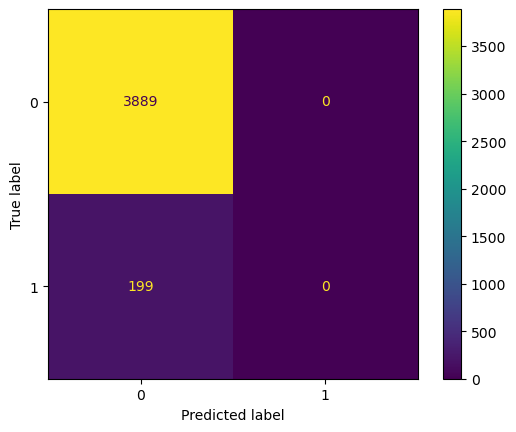

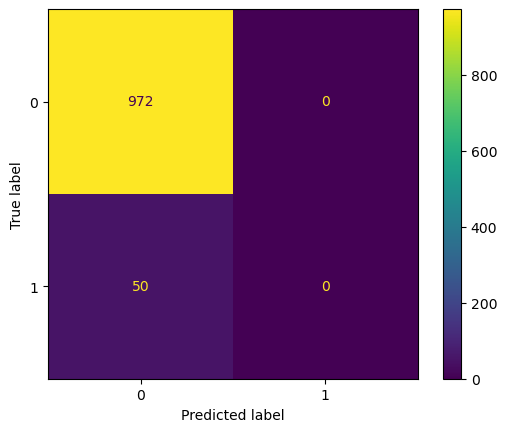

In [89]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# choosing 4 different classification models to predict patients with stroke risk and testing them
# 1 - stochastic gradient descent 
# 2 - decision tree classifier
# 3 - 
sgd_clf = SGDClassifier(random_state=42)
Model(sgd_clf,X_train,Y_train,X_test,Y_test)


Training Score 
 1.0
Testing Score 
 0.9070450097847358
Accuracy  = 0.9070450097847358
Precision = 0.17391304347826086
Recall    = 0.24
F1-score  = 0.20168067226890754
RMSE      = 0.30488520825921384


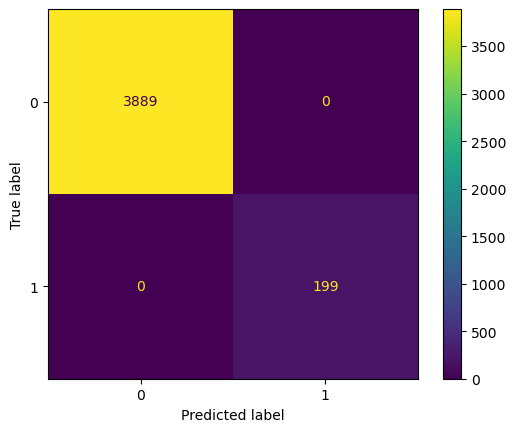

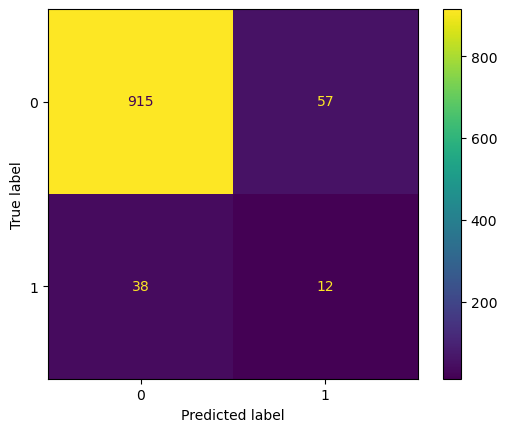

In [90]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=42)
Model(DTC,X_train,Y_train,X_test,Y_test)

Training Score 
 0.951320939334638
Testing Score 
 0.952054794520548
Accuracy  = 0.952054794520548
Precision = 1.0
Recall    = 0.02
F1-score  = 0.0392156862745098
RMSE      = 0.21896393648144905


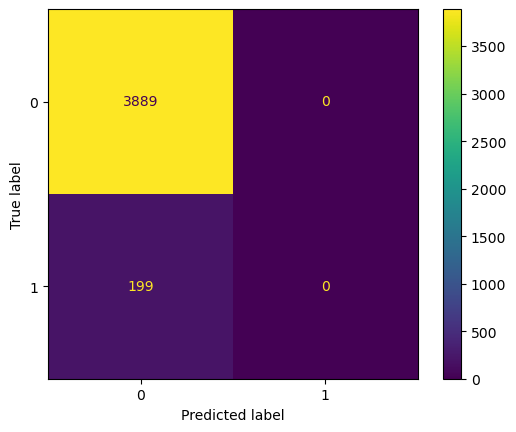

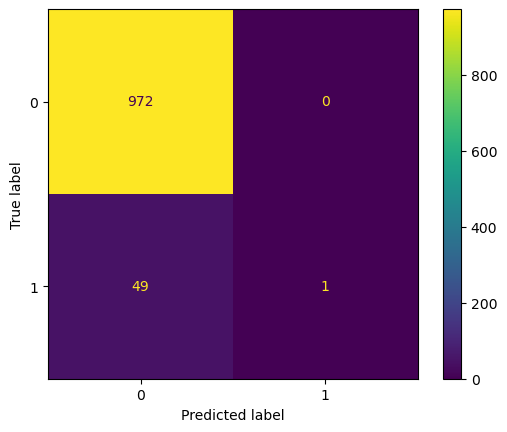

In [94]:
from sklearn.linear_model import LogisticRegression

lg_reg = LogisticRegression(random_state=42)
Model(lg_reg,X_train,Y_train,X_test,Y_test)

Training Score 
 1.0
Testing Score 
 0.9471624266144814
Accuracy  = 0.9471624266144814
Precision = 0.0
Recall    = 0.0
F1-score  = 0.0
RMSE      = 0.22986424990745863


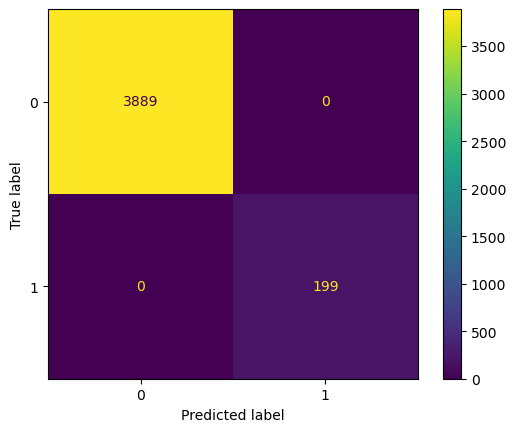

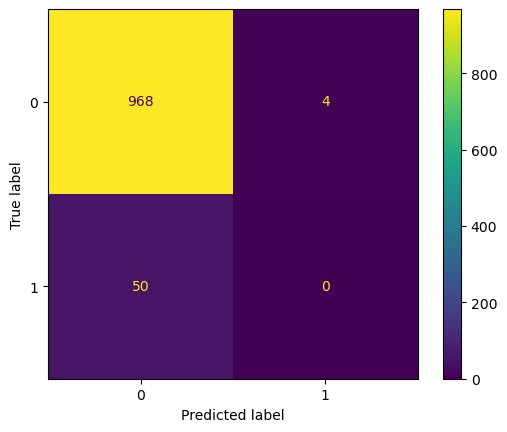

In [93]:
from sklearn.ensemble import 

rf1 = RandomForestClassifier(random_state=42)
Model(rf1,X_train,Y_train,X_test,Y_test) 

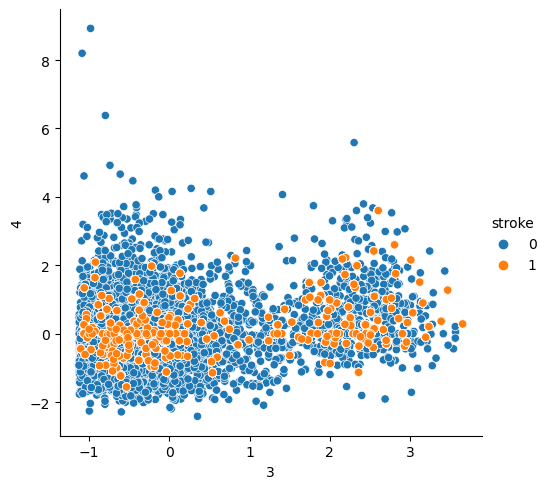

In [97]:
# weak scores of accuracy, precision , recall and F1-score of each chosen models, require us to balance the data. 
# Performence of training data is significantly better than testing data.

# confusion matrix: a table showing correct predictions and types of incorrect predictions.
# precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
# recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
# F1-Score: the weighted average of precision and recall.

# deduction: data requires over-sampling. Using RandomOverSampler to balance data.

from sklearn.model_selection import train_test_split

data_prepared = full_pipeline.fit_transform(data_frame)
y = data_frame.stroke.copy()
rs = RandomOverSampler()
X, Y = rs.fit_resample(data_prepared, y)
x = pd.DataFrame (X)
sns.relplot(data=x, x = x[3], y=x[4], hue = Y ) # fourth column is avg_glucose_level and the fifth is bmi

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, stratify = Y)

Training Score 
 0.951320939334638
Testing Score 
 0.952054794520548
Accuracy  = 0.952054794520548
Precision = 1.0
Recall    = 0.02
F1-score  = 0.0392156862745098
RMSE      = 0.21896393648144905


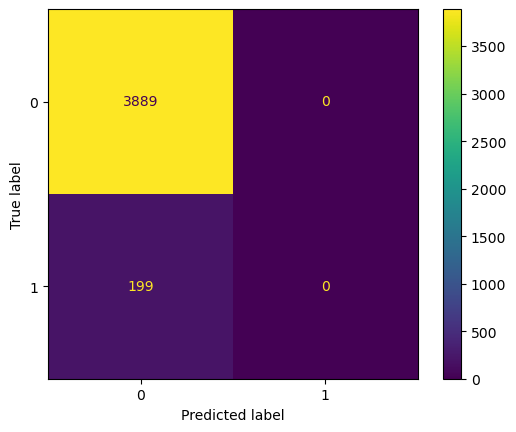

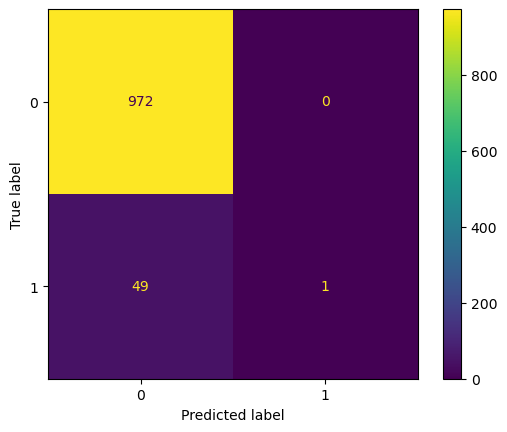

In [115]:
lg_reg = LogisticRegression(random_state=42)
Model(lg_reg,X_train,Y_train,X_test,Y_test)

Training Score 
 1.0
Testing Score 
 0.9070450097847358
Accuracy  = 0.9070450097847358
Precision = 0.17391304347826086
Recall    = 0.24
F1-score  = 0.20168067226890754
RMSE      = 0.30488520825921384


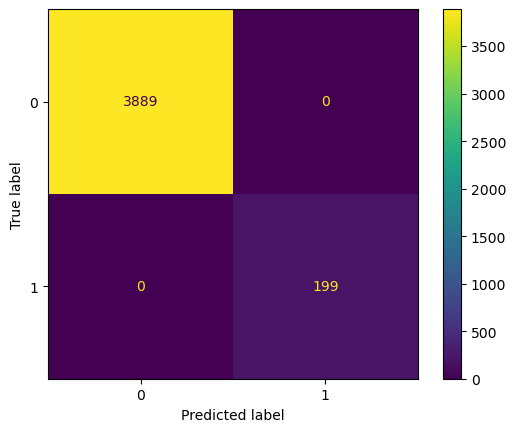

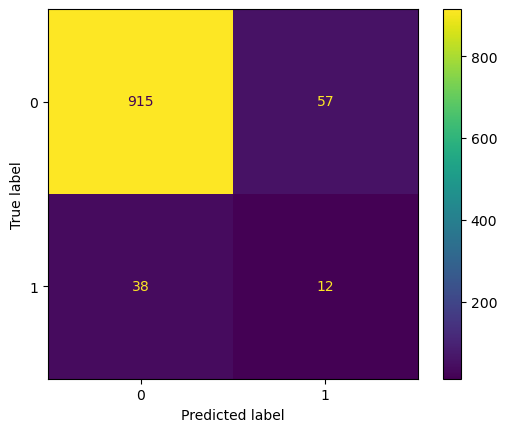

In [116]:
DTC = DecisionTreeClassifier(random_state=42)
Model(DTC,X_train,Y_train,X_test,Y_test)

Training Score 
 0.951320939334638
Testing Score 
 0.9510763209393346
Accuracy  = 0.9510763209393346
Precision = 0.0
Recall    = 0.0
F1-score  = 0.0
RMSE      = 0.2211869776019044


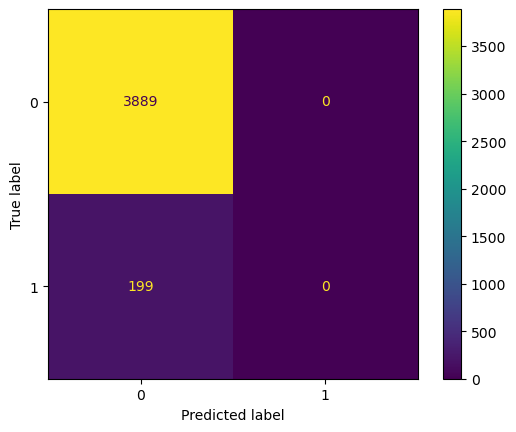

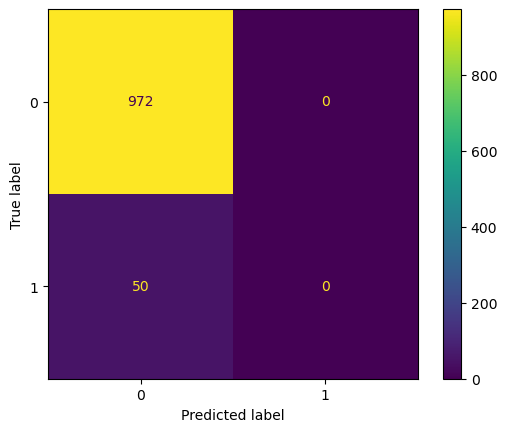

In [102]:
sgd_clf = SGDClassifier(random_state=42)
Model(sgd_clf,X_train,Y_train,X_test,Y_test)

Training Score 
 1.0
Testing Score 
 0.9913615795968738
Accuracy  = 0.9913615795968738
Precision = 0.9830097087378641
Recall    = 1.0
F1-score  = 0.9914320685434517
RMSE      = 0.09294310304227144


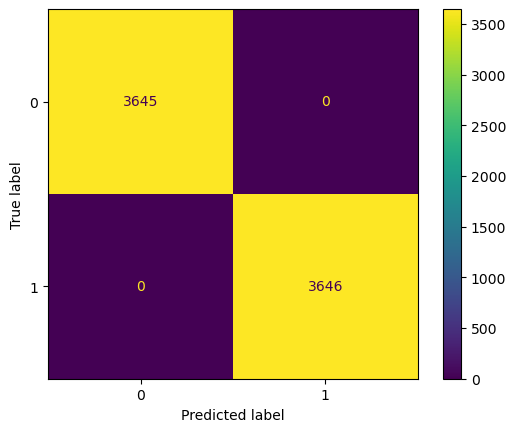

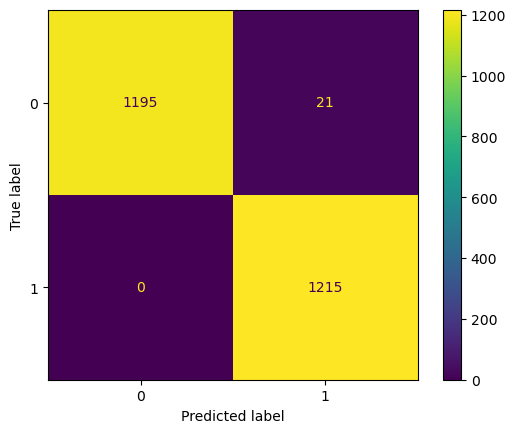

In [117]:
rf1 = RandomForestClassifier(random_state=42)
Model(rf1,x_train,y_train,x_test,y_test)

# after data sampling RandomForestClassifier got the best results. 
# RMSE - in this case has the lowest score which means that room for error is the smallest from the models.
# testing score, accuracy, precision and f1 scores are the highest. 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_features=4, n_estimators=3;, score=(train=-0.007, test=-0.029) total time=   0.0s
[CV 2/5] END max_features=4, n_estimators=3;, score=(train=-0.005, test=-0.025) total time=   0.0s
[CV 3/5] END max_features=4, n_estimators=3;, score=(train=-0.004, test=-0.021) total time=   0.0s
[CV 4/5] END max_features=4, n_estimators=3;, score=(train=-0.006, test=-0.036) total time=   0.0s
[CV 5/5] END max_features=4, n_estimators=3;, score=(train=-0.004, test=-0.030) total time=   0.0s
[CV 1/5] END max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.014) total time=   0.0s
[CV 2/5] END max_features=4, n_estimators=10;, score=(train=-0.001, test=-0.014) total time=   0.0s
[CV 3/5] END max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.014) total time=   0.0s
[CV 4/5] END max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.017) total time=   0.0s
[CV 5/5] END max_features=4, n_estimators=10

[CV 2/5] END bootstrap=False, max_features=4, n_estimators=3;, score=(train=-0.000, test=-0.018) total time=   0.0s
[CV 3/5] END bootstrap=False, max_features=4, n_estimators=3;, score=(train=-0.000, test=-0.014) total time=   0.0s
[CV 4/5] END bootstrap=False, max_features=4, n_estimators=3;, score=(train=-0.000, test=-0.017) total time=   0.0s
[CV 5/5] END bootstrap=False, max_features=4, n_estimators=3;, score=(train=-0.000, test=-0.022) total time=   0.0s
[CV 1/5] END bootstrap=False, max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.005) total time=   0.0s
[CV 2/5] END bootstrap=False, max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.009) total time=   0.0s
[CV 3/5] END bootstrap=False, max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.005) total time=   0.0s
[CV 4/5] END bootstrap=False, max_features=4, n_estimators=10;, score=(train=-0.000, test=-0.008) total time=   0.0s
[CV 5/5] END bootstrap=False, max_features=4, n_estimators=10;, scor

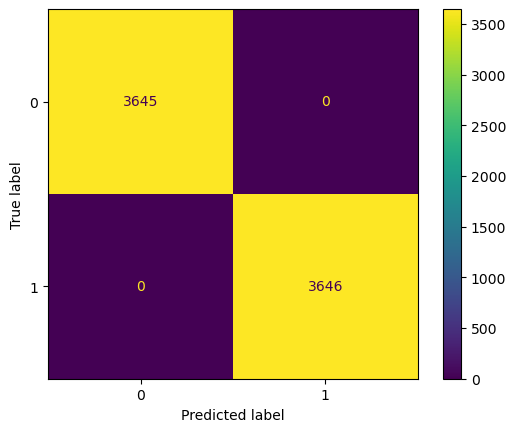

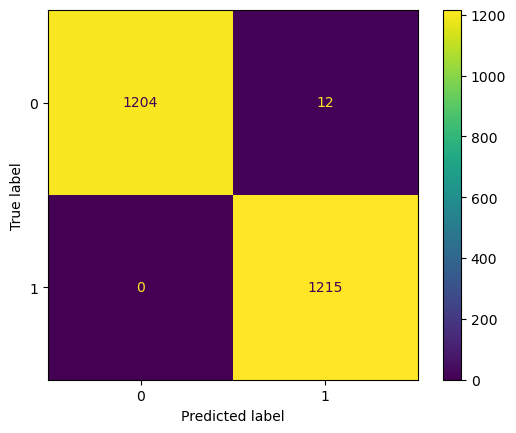

In [106]:
# fine tunning model 

# before 
# training Score = 1.0
# testing Score = 0.9913615795968738
# accuracy  = 0.9913615795968738
# precision = 0.9830097087378641
# recall    = 1.0
# f1-score  = 0.9914320685434517
# RMSE      = 0.09294310304227144

# after
# training Score = 1.0
# testing Score = 0.9950637597696421
# accuracy  = 0.9950637597696421
# precision = 0.9902200488997555
# recall    = 1.0
# f1-score  = 0.995085995085995
# RMSE      = 0.07025838192242885

#Slight improvement of the model is visible. 


from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [4, 6, 8, 10]},              
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

rf = RandomForestClassifier(random_state = 42)
# train across 5 folds (cv=5), that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True, verbose=3)
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

final_model = grid_search.best_estimator_
Model(final_model,x_train,y_train,x_test,y_test)

some_data = x_test[:10]
some_labels = y_test[:10]

# It is visible that predicitons are in line with actual values.
print("Predictions: ", final_model.predict(some_data))
print("Actual value:", list(some_labels))

32/32 [==============================] - 0s 1ms/step - loss: 0.7552 - accuracy: 0.9511


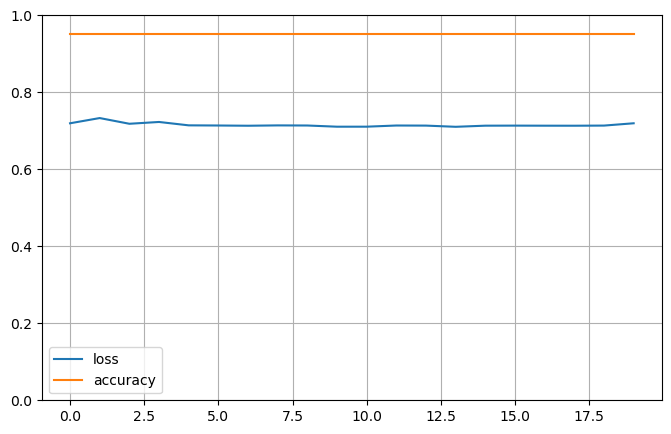

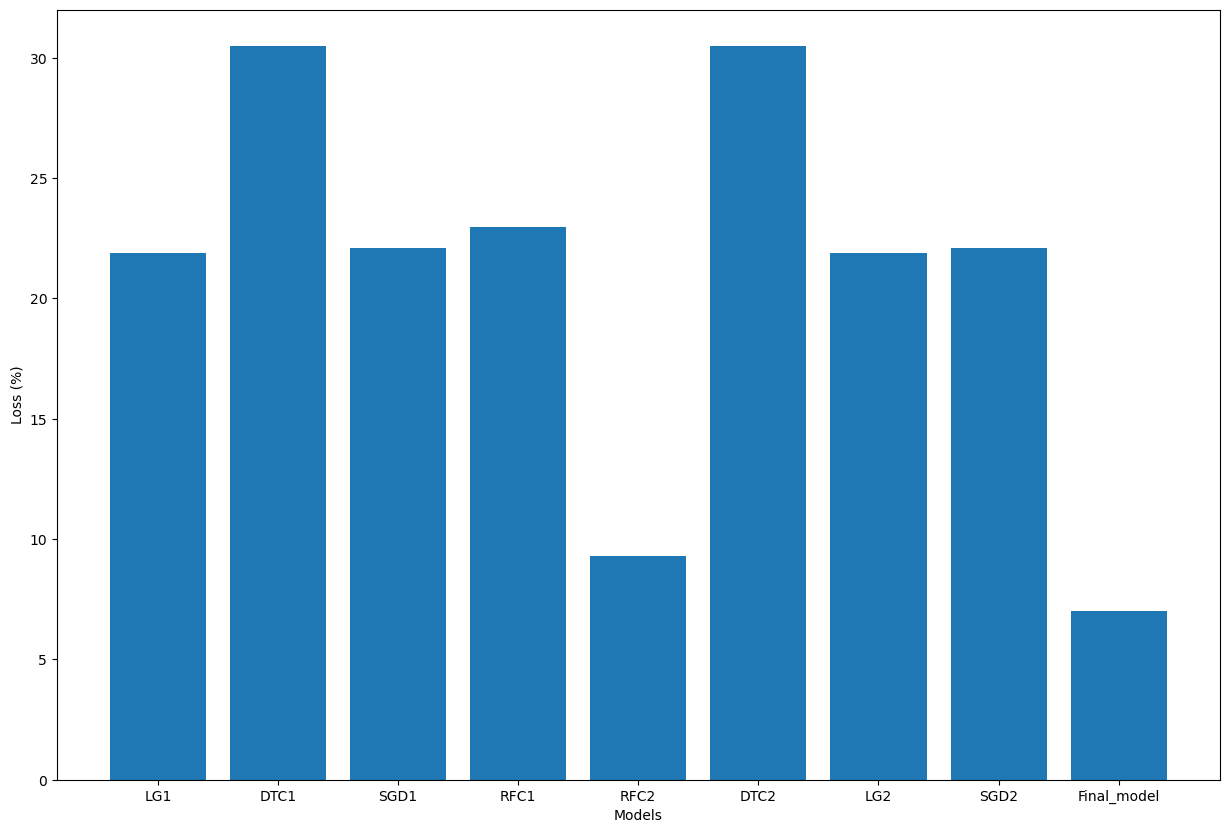

In [119]:
mse_test = model.evaluate(X_test, Y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

bar_categories = ['LG1', 'DTC1', 'SGD1', 'RFC1', 'RFC2', 'DTC2','LG2', 'SGD2','Final_model']
bars = [21.89 , 30.48, 22.11, 22.98, 9.29, 30.48, 21.89, 22.11, 7.02]

plt.figure(figsize=(15,10))
plt.bar(bar_categories, bars)
plt.xlabel('Models') 
plt.ylabel('Loss (%)') 
plt.show()

#Below presented accuracy and loss for particular model. Results are confirming that final is the best choice.

In [122]:
#Saving my model
import joblib

my_model  = Pipeline([
        ("preparation", full_pipeline),
        ("RFC", RandomForestClassifier())])

joblib.dump(my_model, "my_stroke_prediciton_model.pkl") #Saving my model

['my_stroke_prediciton_model.pkl']